# Titanic Kaggle Competition

This notebook is about implementing a full Machine Learning pipeline, using the famous ML competition platform Kaggle. The goal is to participate to the "Titanic" competition, consisting of predicting survivors in the shipwreck.

### Libraries

In [1]:
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")     # for seaborn issue

import pandas as pd                   # Munging
import numpy as np                    # Munging
import re                             # Regular expressions
import seaborn as sns                 # Visualisation
import matplotlib.pyplot as plt       # Visualisation

# Modeling
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

sns.set(style='white', context='notebook')
sns.set_palette("PuOr")

## Getting and understanding the data

Let us first load the file as datasets, and then see what it looks like as a table.

In [2]:
# Load the datasets
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

# What is the structure?
print("Length of the train dataset: " + str(len(train.index)))
train.head(5)

Length of the train dataset: 891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can observe our 12 initial features, which were already described in the homework Pdf document. We can see than the *Cabin* variable has some *NaN* (Not a Number, or empty) values. Let's check the null values for all the dataset features.

In [3]:
# Take a look at NA count per features
pd.DataFrame(train.isnull().sum())

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


Only 3 features possess *NaNs*, with *Embarked* having only 2. However, *Cabin* has 682 null values for 891 rows, which is a lot. We will take care of missing values later. 

Some features can also convey the same information. A **correlation matrix** can give us a good idea of related features.

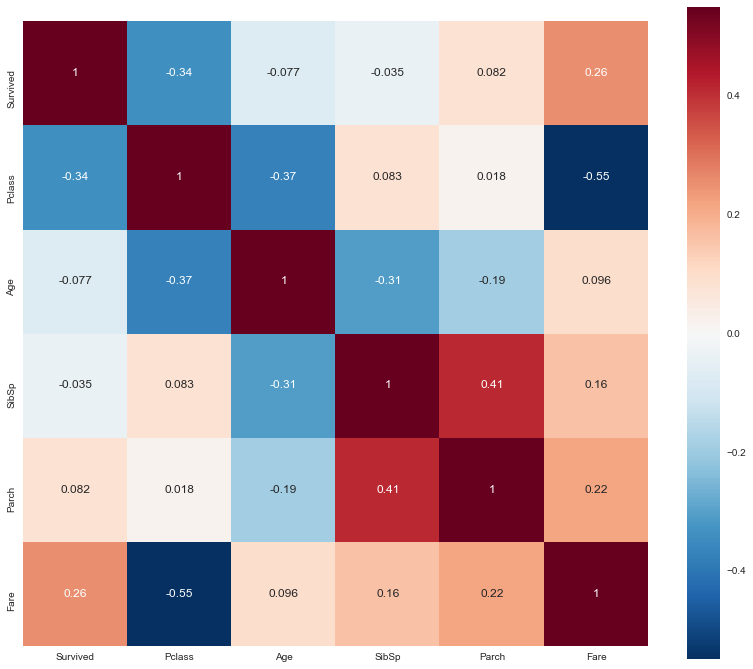

In [4]:
# Take a look at inter-feature correlations
plt.figure(figsize=(14,12))
sns.heatmap(train.drop('PassengerId',axis=1).corr(),
            vmax=0.5,
            square=True,
            annot=True)

Some features a well correlated, such as *Pclass* and *Fare* that are negatively correlated with .55 (which makes sense as the first class is the more expensive and the 3rd class is the cheapest). However, **no feature needs to be removed** because giving the exact same information than another one.<br>

We can also check the **distribution** of each of our features with an histogram matrix:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a2426a0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a7ca2b0>]], dtype=object)

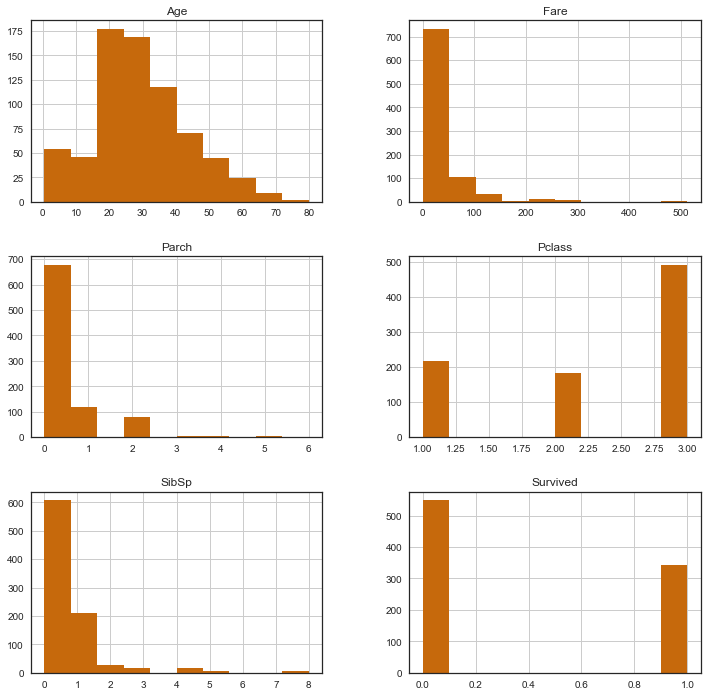

In [5]:
train.drop('PassengerId',axis=1).hist(figsize=(12,12))

Seemingly, we can learn from that graph the following insights :
- The population on the ship tends to be young
- The boat was mainly populated by individuals, couples or small families
- Very high ticket prices are relatively rare
- 3rd class is the more common one, but there is actually more 1st class passengers than 2nd class ones
- Unfortunately, as history taught us there is more people that did not survive than people than survived

## Feature Engineering

Now that we know what data we are working on, let's do some feature cleaning, improving and some feature creation.<br>
This manipulations have to be done on both the training and the test set. So **putting them together can will avoid repetitive code**.

In [6]:
dataset = pd.concat([train.drop('Survived',1),test])

### Missing Data

In [7]:
# missing values for Embarked
dataset[dataset['Embarked'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


We have 2 missing values here. It's very small and the feature is likely to be useful for modeling. A good solution is to fill them with another non null value. How should we process?

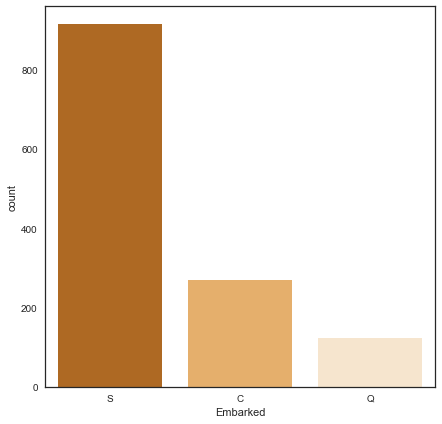

In [8]:
fig, ax = plt.subplots(figsize=(7,7))
sns.countplot(x='Embarked', 
              data=dataset,
              ax=ax,
              order = ["S","C","Q"])

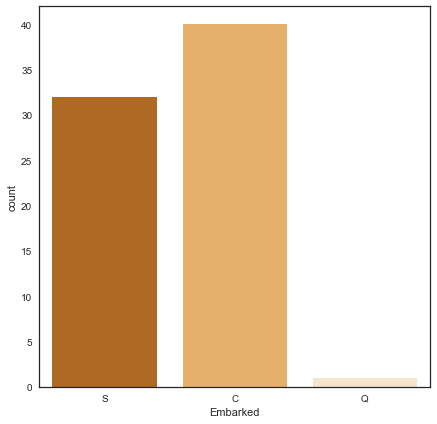

In [9]:
fig, ax = plt.subplots(figsize=(7,7))
sns.countplot(x='Embarked', 
              data=dataset[(dataset["Sex"]=="female") & (dataset["Pclass"]==1) & (dataset["Age"]>=35)],
              ax=ax,
              order = ["S","C","Q"])

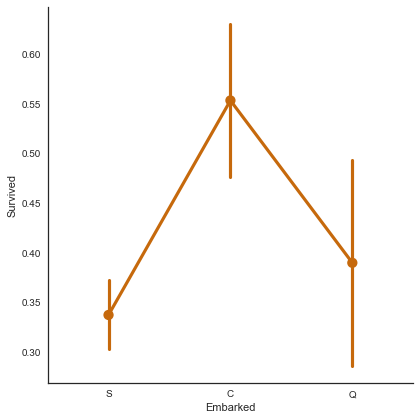

In [10]:
sns.factorplot('Embarked',
               'Survived',
               data=train,
               size=6)

Okay, so this 3 graph actually gives us a really interesting choice. The easy go to solution would be to replace the *NaN* by an "S", because this is the more common Harbor in the dataset. <br>

However, if we take a look at our *NaN* row, we see that our mysterious travelers actually are **both Women, relatively old and in 1st class**. And for that type of traveler, the Harbor C is highly probable. <br>

Moreover, travelers coming from Harbor C seem to have an **significantly higher chance of survival. That is why we decide to use "C" to replace our NaN values here.**

In [11]:
# filling of missing values for Embarked
dataset['Embarked'].iloc[61] = "C"
dataset['Embarked'].iloc[829] = "C"

For the variable *Fare*, a continuous variable for now (the price of the ticket), we can simply use the efficient method that consists in filling *NaNs* with the median.

In [12]:
pd.DataFrame(dataset[dataset['Fare'].isnull()])

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [13]:
# filling of missing values for Fare in the test set
dataset.loc[152, 'Fare'] = dataset['Fare'][dataset['Pclass'] == 3].dropna().median()

We now want to tackle the missing value for the feature *Age*. Taking a look at what we have again:

In [14]:
dataset[dataset['Age'].isnull()].count()

PassengerId    263
Pclass         263
Name           263
Sex            263
Age              0
SibSp          263
Parch          263
Ticket         263
Fare           263
Cabin           23
Embarked       263
dtype: int64

There is definitely **a lot** of them. We have to do something a bit more elaborated than **simply the entire dataset mean** for *Age*.
<br>

Actually, if we take a look a the names of our travelers, there is an important information that may help us with finding the potential age of a person: **the title**. We have to extract it, and look how this relates to our population's age.

In [15]:
# Extract and reduce the number of title
dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

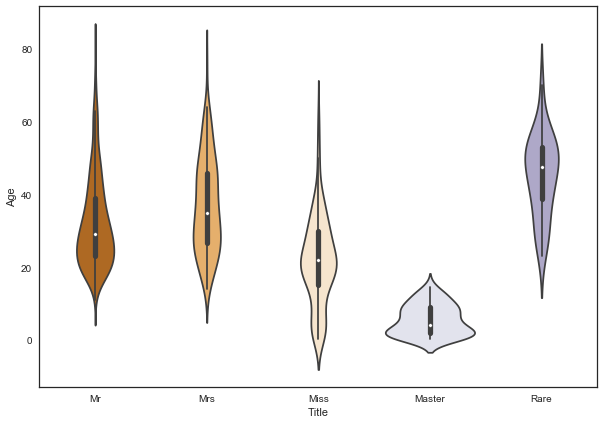

In [16]:
# Plot to observe trends
fig, ax = plt.subplots(figsize=(10,7))
sns.violinplot(x="Title",
               y="Age",
               data=dataset,
               split=True, ax=ax)

Okay, there is definitely an interesting solution for our *Age* missing values with the titles:

We are going to **replace our unknown age travelers info with the average age for their title.**

In [17]:
# Replace missing age values with mean for the titles
titlemapping = dataset[['Title','Age']].groupby('Title').mean().to_dict(orient='dict')['Age']
dataset.loc[dataset.Age.isnull(), 'Age'] = dataset[dataset.Age.isnull()].Title.map(titlemapping)

Title
Master    AxesSubplot(0.125,0.125;0.775x0.755)
Miss      AxesSubplot(0.125,0.125;0.775x0.755)
Mr        AxesSubplot(0.125,0.125;0.775x0.755)
Mrs       AxesSubplot(0.125,0.125;0.775x0.755)
Rare      AxesSubplot(0.125,0.125;0.775x0.755)
Name: Age, dtype: object

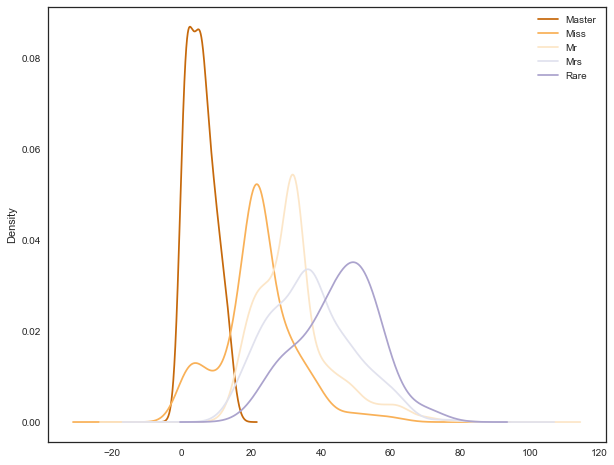

In [18]:
dataset.groupby('Title').Age.plot(kind='kde',
                                  legend=True,
                                  figsize=(10,8))

Looking at the age distribution per group again here, we see that this choice seem to provide a good accurate alternative for *NaN* replacement. 
<br><br>
The only remaining feature with null values is now *Cabin*. However, the ratio $\frac{null}{available}$ is way to high to make a correct filling. We can't fix that one!

### Feature creation

Now that our variables are "fixed", we can focus on creating new interesting variables from the existing ones. As a refresher, here is the current features:

In [19]:
pd.DataFrame(dataset.columns).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11
0,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


- *PassengerId* can't be used as a base for new interesting variables. It is more of an index feature.
- *Pclass* is really straightforward, and we decide to let it as it.
- *Name* has already been exploited by extracting the titles

*Age* can be used for a new binary variable. During the evacuation, they had the instruction to give priority to children of 12 years old or less. Children below that age have then a greater change of survival.



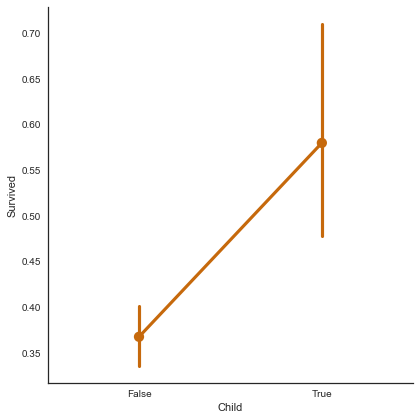

In [20]:
train['Child'] = train['Age']<=12

sns.factorplot(x="Child", y="Survived", data=train, size=6)

This hypothesis is verified on the labeled train dataset. We can create the variable for the full dataset.

As well, there may be a **difference in survival rate between young people and older ones**(physical differences, or different prioritization, or social status leading to different class tickets)

In [21]:
dataset['Child'] = dataset['Age']<=12
dataset['Young'] = (dataset['Age']<=30) | (dataset['Title'].isin(['Master','Miss','Mlle']))

We arrive at *SibSp* -the number of siblings or spouse- and the similar one *Parch* -the number of Parents or children- that can make **interesting combinations**.

For example, summing the two variables can gives us the size of the family for each traveler (+1 for the traveler itself). **Do important families tend to survive more?**

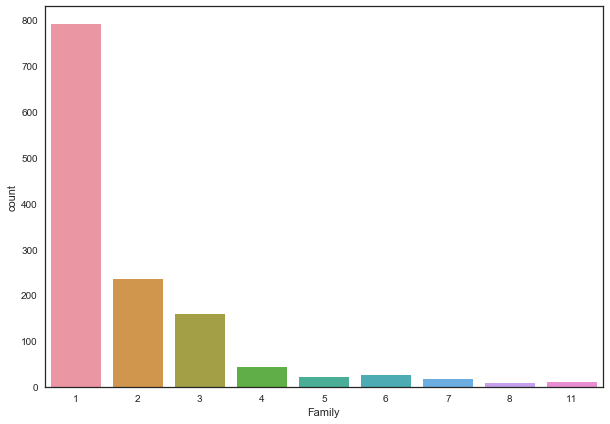

In [22]:
dataset['Family'] = dataset['SibSp'] + dataset['Parch'] + 1

fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(x='Family', data=dataset, ax=ax)

Quite interesting. Unfortunately **this is not the case**. We can even say that large family tend to have a lower chance of survival and alone travelers a higher one. We can create **more meaningful variable from this analysis**.

In [23]:
dataset['Alone']  = dataset['Family'] == 1
dataset['Large_Family'] = dataset['Family'] > 3

Now come the feature *Tickets*. The ticket number can be shared for people traveling together. Let's see if being part of a group have an influence on surviving chances.

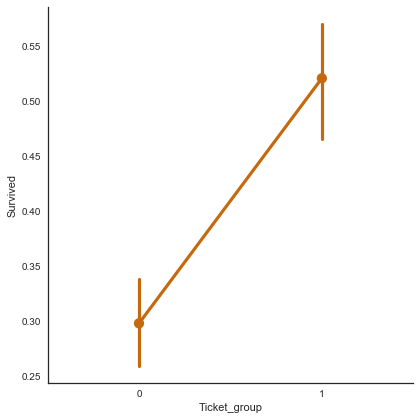

In [24]:
train['Ticket_group'] = np.where(train.groupby('Ticket')['Name'].transform('count') > 1, 1, 0)
sns.factorplot(x="Ticket_group", y="Survived", data=train, size=6)

Being part of a group surely have an impact on survival chances. Now, how does the specific size of that group impact the chances?

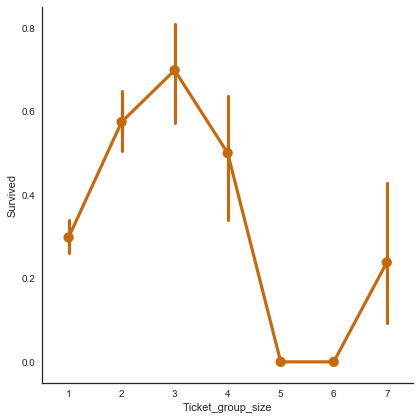

In [25]:
# Ticket group size on labeled data train
train['Ticket_group_size'] = train.groupby('Ticket')['Name'].transform('count')

# Chance of survival according to group size
sns.factorplot(x="Ticket_group_size", y="Survived", data=train, size=6)

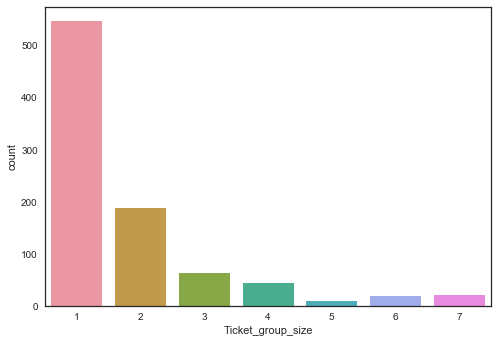

In [26]:
# Count of those groups
sns.countplot(x="Ticket_group_size", data=train)

Okay, so the group size may be important: **Being part of a small group improves surviving chances**, but **large groups tend not to survive** (even if our sample is not big enough to have solid conclusions). Let's just create a feature for small_group and a feature for big_group, following a similar logic than Family size.

In [27]:
# Ticket group size on full data
dataset['Ticket_group_size'] = dataset.groupby('Ticket')['Name'].transform('count')

dataset['Small_group']  = (dataset['Ticket_group_size'] > 1) & (dataset['Ticket_group_size'] < 5)
dataset['Large_group'] = dataset['Ticket_group_size'] > 5

Also from the tickets number, we can extract the first part indicating a type. But is there differences between them?

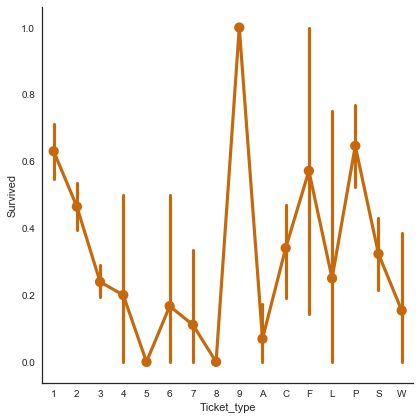

In [28]:
# Ticket type on the dataset
train['Ticket_type'] = train['Ticket'].str[0]

sns.factorplot(x="Ticket_type",
               y="Survived",
               data=train,
               size=6,
               order=["1","2","3","4","5","6","7","8","9","A","C","F","L","P","S","W"])

If we take 0.5 as a threshold, we can see that **some types of tickets offer more chance of survival than others**. Let's see if a *Deadly_ticket* is interesting:

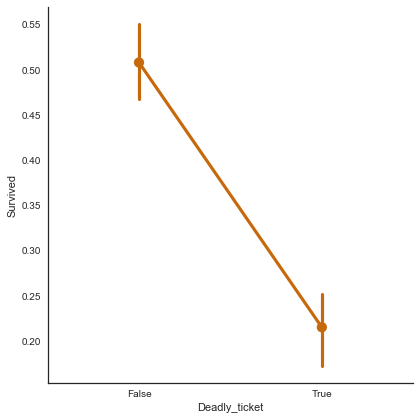

In [29]:
train['Deadly_ticket'] = train['Ticket_type'].isin(['3','4','5','6','7','8','A','L','W'])

sns.factorplot(x="Deadly_ticket", y="Survived", data=train, size=6)

This can be useful as a new feature on the full dataset!

In [30]:
# Deadly_ticket for the full dataset
dataset['Ticket_type'] = dataset['Ticket'].str[0]
dataset['Deadly_ticket'] = dataset['Ticket_type'].isin(['3','4','5','6','7','8','A','L','W'])

Now, we still have 3 features to go: *Fare* and *Cabin* ! We will then be done with feature creation and will be able to do a last manipulation for modeling preparation: categorization.

*Fare* is actually quite descriptive already. We may want to create a categorical feature out of it later.

What about *Cabin* ?

In [31]:
dataset.Cabin.head(5)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

There is of course a lot of *NaN* values for *Cabin*. However some information can still be extracted from the available data. If we take a look at the Titanic:

<img src="./Plan.png",width=400,height=400>

So, the first letters stand for the highest decks in the boat. Which we may assume will lead to higher chances of survival.

In [32]:
dataset['Deck'] = dataset['Cabin'].str[0]

But as we are a lot of *NaN*, we can replace this value as a letter so we won't have trouble during categorization later. Like U (Unknown)

In [33]:
dataset['Deck'] = dataset['Deck'].fillna(value='U') #filling missing value for Deck

### Feature categorization
<br>
We are now done with new features creation from the available ones. We just want to change the format of certain features for another one more adapted to modeling (related to how models don't handle string variables).

In [34]:
dataset["Title"] = dataset["Title"].astype("category")
dataset["Title"].cat.categories = [0,1,2,3,4]

dataset["Sex"] = dataset["Sex"].astype("category")
dataset["Sex"].cat.categories = [0,1]

dataset["Child"] = dataset["Child"].astype("category")
dataset["Child"].cat.categories = [0,1]

dataset["Young"] = dataset["Young"].astype("category")
dataset["Young"].cat.categories = [0,1]

dataset["Alone"] = dataset["Alone"].astype("category")
dataset["Alone"].cat.categories = [0,1]

dataset["Large_Family"] = dataset["Large_Family"].astype("category")
dataset["Large_Family"].cat.categories = [0,1]

dataset["Small_group"] = dataset["Small_group"].astype("category")
dataset["Small_group"].cat.categories = [0,1]

dataset["Large_group"] = dataset["Large_group"].astype("category")
dataset["Large_group"].cat.categories = [0,1]

dataset["Deadly_ticket"] = dataset["Deadly_ticket"].astype("category")
dataset["Deadly_ticket"].cat.categories = [0,1]

dataset["Deck"] = dataset["Deck"].astype("category")
dataset["Deck"].cat.categories = [0,1,2,3,4,5,6,7,8]

dataset["Embarked"] = dataset["Embarked"].astype("category")
dataset["Embarked"].cat.categories = [0,1,2]

dataset["Deadly_ticket"] = dataset["Deadly_ticket"].astype("category")
dataset["Deadly_ticket"].cat.categories = [0,1]

dataset['Age_cat'] =  pd.qcut(dataset['Age'], 4)
dataset['Age_cat'].cat.categories = [0,1,2,3]

dataset['Fare_cat'] =  pd.qcut(dataset['Fare'], 4)
dataset['Fare_cat'].cat.categories = [0,1,2,3]

In [35]:
dataset.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Child', 'Young',
       'Family', 'Alone', 'Large_Family', 'Ticket_group_size', 'Small_group',
       'Large_group', 'Ticket_type', 'Deadly_ticket', 'Deck', 'Age_cat',
       'Fare_cat'],
      dtype='object')

We should remove the initial features that contains the same information than the one we created:

In [36]:
drop_list = ["PassengerId", "Name", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin","Ticket_type"]
dataset = dataset.drop(drop_list, axis=1)

## Modeling

Finally time for creating and testing our models! 
But first, we have to put our combined dataset as it was before the data crunching: separated in the training and testing part.

### Model testing


In [37]:
train_improved = dataset.iloc[:len(train)]
test_improved = dataset.iloc[len(train):]
train_improved['Survived'] = train.Survived

We also have to split our new train_improved dataset in a test and train part for evaluating our models before actually do predictions on the true test data.

In [38]:
train_split, test_split = train_test_split(train_improved, test_size=0.2, random_state=0)

And to define our dependent and predicting variables 

In [39]:
X_train = train_split.drop("Survived",axis=1)
Y_train = train_split["Survived"]
X_test  = test_split.drop("Survived",axis=1)
Y_test = test_split["Survived"]

A usually good idea to start with is a Random Forest classifier, because it is both:
- easy to code with the right library (scikit-learn here)
- really well performing a large part of the time
- quite practical to understand, as we can see the "reasoning" and important variables of the model

In [40]:
# First try: Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_test, Y_test)

0.83240223463687146

This is a very good start! However, that model trained on the entire train set and predicting the true test set **scores 0.78 on Kaggle**.

Let's try other, even more simple models and compare the accuracy on the test set. We will then try more elaborated models to get this accuracy score growing if possible.

In [41]:
# Support Vector Machines
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
svc.score(X_test, Y_test)

0.84916201117318435

In [42]:
# K Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
knn.score(X_test, Y_test)

0.78212290502793291

In [43]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
logreg.score(X_test, Y_test)

0.81005586592178769

In [44]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
gaussian.score(X_test, Y_test)

0.81564245810055869

As expected, the **Random Forest model performs better than the other one we tested, out of the box**. Before getting into more complex construction such as Ensemble Learning, we can try **hyperparameters optimization** for some of the above models.

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Support Vector Machines with hyperparameters optimization
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-1,1e-2,1e-3, 1e-4,1e-5],
                     'C': [0.1, 1, 10, 100, 1000, 10000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

opt_svc = GridSearchCV(SVC(), tuned_parameters)
opt_svc.fit(X_train, Y_train)
print(opt_svc.best_params_)
Y_pred = opt_svc.predict(X_test)
opt_svc.score(X_test, Y_test)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


0.83240223463687146

In [46]:
# Support Vector Machines with hyperparameters optimization
tuned_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

opt_logreg = GridSearchCV(LogisticRegression(), tuned_parameters)
opt_logreg.fit(X_train, Y_train)
print(opt_logreg.best_params_)
Y_pred = opt_logreg.predict(X_test)
opt_logreg.score(X_test, Y_test)

{'C': 1}


0.81005586592178769

This GridSearch Optimization does not seem to bring any additional accuracy gain here. Let's try another more complex structure by using **XGBoost**.

In [64]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

nonnumeric_columns = ['Sex',
                     'Embarked',
                     'Title',
                     'Child',
                     'Young',
                     'Alone',
                     'Large_Family',
                     'Small_group',
                     'Large_group',
                     'Deadly_ticket',
                     'Deck',
                     'Age_cat',
                     'Fare_cat'
                     ]
le = LabelEncoder()
for feature in nonnumeric_columns:
    X_train[feature] = le.fit_transform(X_train[feature])
    X_test[feature] = le.fit_transform(X_test[feature])
    
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, Y_train)
predictions = gbm.predict(X_test)
gbm.score(X_test, Y_test)

0.82122905027932958

### Kaggle submission

In [ ]:
# Support Vector Machines
#svc = SVC()
#svc.fit(train_improved.drop("Survived",axis=1), train_improved["Survived"])
#Y_pred = svc.predict(test_improved)

In [66]:
for feature in nonnumeric_columns:
    X_train[feature] = le.fit_transform(train_improved.drop(["Survived", "Family","Ticket_group_size"],axis=1)[feature])
    X_test[feature] = le.fit_transform(test_improved[feature])
    
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(X_train, train_improved["Survived"])
predictions = gbm.predict(X_test)

ValueError: Length of values does not match length of index

In [ ]:
# Kaggle prediction
#Passenger_ID = test['PassengerId']
#results  = pd.DataFrame(Y_pred)
#results = pd.concat([Passenger_ID,results],axis=1)
#results.columns =['PassengerId','Survived']
#results.to_csv('results2',index =False)

### Thank you note

I would like to thanks the people working with me on that notebook, as well as some kernels editors on Kaggle that have been very helpful.